### Import Dependencies

In [3542]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sktime.utils.plotting import plot_series
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

from statsmodels.tsa.api import VAR

### Global Notebook Parameters

In [3543]:
base_dir = "/home/jovyan/work/Jupyter Notebook/IUBH/Inference_and_Causality/"
os.chdir(base_dir)
os.getcwd()

'/home/jovyan/work/Jupyter Notebook/IUBH/Inference_and_Causality'

In [3544]:
start_date = '2018-01-02'
end_date = '2023-07-01'

In [3545]:
start_dt = datetime.strptime(start_date, "%Y-%m-%d")
end_dt = datetime.strptime(end_date, "%Y-%m-%d")
dates_diff = end_dt - start_dt
number_of_days = dates_diff.days
number_of_days

2006

In [3546]:
date_df = pd.DataFrame({'date': pd.date_range(start=start_date, periods=number_of_days, freq='D')})

In [3547]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2006 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 15.8 KB


### Read Kaggle Stock Market Data File

In [3548]:
kaggle_data_filename = "kaggle_stock_market_data.csv"

In [3549]:
stock_market_df = pd.read_csv(kaggle_data_filename, header=0)

In [3550]:
stock_market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Company     25160 non-null  object
 1   Date        25160 non-null  object
 2   Close/Last  25160 non-null  object
 3   Volume      25160 non-null  int64 
 4   Open        25160 non-null  object
 5   High        25160 non-null  object
 6   Low         25160 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


In [3551]:
stock_market_df['Company'].unique()

array(['AAPL', 'SBUX', 'MSFT', 'CSCO', 'QCOM', 'META', 'AMZN', 'TSLA',
       'AMD', 'NFLX'], dtype=object)

In [3552]:
stock_market_df[ stock_market_df['Company'] == 'MSFT' ].head()

,Company,Date,Close/Last,Volume,Open,High,Low
5032,MSFT,07/17/2023,$345.73,20363930,$345.678,$346.99,$342.20
5033,MSFT,07/14/2023,$345.24,28352730,$347.59,$351.43,$344.31
5034,MSFT,07/13/2023,$342.66,20567160,$339.56,$343.74,$339.02
5035,MSFT,07-12-2023,$337.20,29995260,$336.60,$341.652,$335.67
5036,MSFT,07-11-2023,$332.47,26698220,$331.06,$332.86,$327.00


### Filter & Clean & Format - Microsoft Stock Close Price Data

In [3553]:
sm_df = stock_market_df.rename(columns={'Company':'company',
                                        'Date': 'date',
                                        'Close/Last':'close',
                                        'Volume': 'volume',
                                        'Open': 'open',
                                        'High': 'high',
                                        'Low': 'low'})

sm_df['date'] = pd.to_datetime(stock_market_df['Date'], format="mixed")
sm_df['close_price'] = stock_market_df['Close/Last'].apply(func=lambda x: np.float64(x[1:]) )

sm_df.sort_values(by='date', inplace=True)
sm_df.drop(columns=['close', 'volume', 'open', 'high', 'low'], axis=1, inplace=True)

In [3554]:
# Filter out Microsoft's closing stock price values from the Kaggle dataset
microsoft_filtered_df = sm_df[ (sm_df['company'] == 'MSFT') & (sm_df['date'] >= start_date) & (sm_df['date'] <= end_date) ].loc[:, ['date', 'close_price']]

microsoft_joined_df = pd.merge(date_df, microsoft_filtered_df, on='date', how='left')

microsoft_joined_df.sort_values(by='date', inplace=True)

microsoft_joined_df.set_index('date', inplace=True)

microsoft_joined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2006 entries, 2018-01-02 to 2023-06-30
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close_price  1383 non-null   float64
dtypes: float64(1)
memory usage: 31.3 KB


In [3555]:
microsoft_joined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
close_price,1383.0,201.976088,76.4195,85.01,126.57,212.46,264.59,348.1


(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='Stock Closing Price ($)'>)

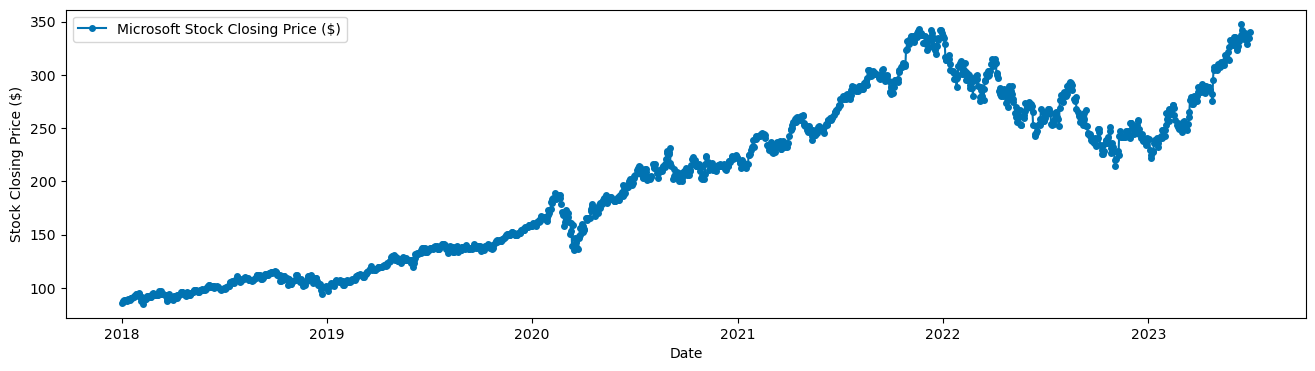

In [3556]:
plot_series(microsoft_joined_df,
            y_label='Stock Closing Price ($)',
            x_label='Date',
            labels=['Microsoft Stock Closing Price ($)'])

### Handling Missing Values - Microsoft Stock Close Price Data

In [3557]:
msft_start_dt = np.datetime_as_string(date_df.iloc[0].values[0], unit='D') 
msft_end_dt = np.datetime_as_string(date_df.iloc[4].values[0], unit='D')

microsoft_start_mean = microsoft_joined_df.loc[msft_start_dt: msft_end_dt, 'close_price'].mean()
print(f"Microsoft's mean stock close price was ${ round(microsoft_start_mean, 2) } between the period of {msft_start_dt} and {msft_end_dt}.") 

Microsoft's mean stock close price was $86.9 between the period of 2018-01-02 and 2018-01-06.


In [3558]:
# Replace the first two day's NaN values with the mean stock closing price
msft_1st_dt = np.datetime_as_string(date_df.iloc[0].values[0], unit='D') 
microsoft_joined_df.loc[msft_1st_dt, 'close_price'] = microsoft_start_mean

msft_2nd_dt = np.datetime_as_string(date_df.iloc[1].values[0], unit='D')
microsoft_joined_df.loc[msft_2nd_dt, 'close_price'] = microsoft_start_mean

In [3559]:
# Calculate the rolling mean stock closing price over a window of 5 days
microsoft_joined_df['close_price_rolling_mean'] = microsoft_joined_df['close_price'].rolling(window=5, min_periods=2).mean()

In [3560]:
microsoft_joined_df.head()

,close_price,close_price_rolling_mean
2018-01-02,86.90,NaN
2018-01-03,86.90,86.900
2018-01-04,87.11,86.970
2018-01-05,88.19,87.275
2018-01-06,NaN,87.275


In [3561]:
# Replace any NaN (missing) stock close price values with the rolling mean stock price value
for index, row in microsoft_joined_df.iterrows():

    close_price = microsoft_joined_df.loc[index, 'close_price']

    if np.isnan(close_price):

        microsoft_joined_df.loc[index, 'close_price'] = round(microsoft_joined_df.loc[index, 'close_price_rolling_mean'], 2)

In [3562]:
# Drop the 'close_price_rolling_mean' column from the dataframe
microsoft_joined_df.drop(columns=['close_price_rolling_mean'], axis=1, inplace=True)

In [3563]:
# Sort the dataframe based on the dataframe's index dates
microsoft_cleaned_df = microsoft_joined_df.sort_index()

In [3564]:
microsoft_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2006 entries, 2018-01-02 to 2023-06-30
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close_price  2006 non-null   float64
dtypes: float64(1)
memory usage: 95.9 KB


In [3565]:
microsoft_cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
close_price,2006.0,201.846615,76.363303,85.01,126.7875,212.445,264.25,348.1


(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='Stock Closing Price ($)'>)

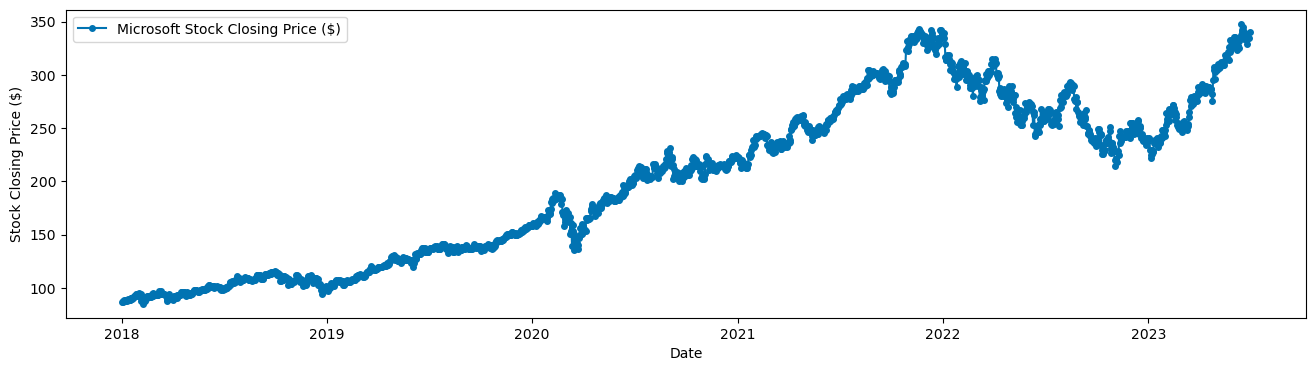

In [3566]:
plot_series(microsoft_cleaned_df,
            y_label='Stock Closing Price ($)',
            x_label='Date',
            labels=['Microsoft Stock Closing Price ($)'])

### Read SP500 Index Data File

In [3567]:
sp500_data_filename = "sp500_index.csv"

In [3568]:
sp500_index_df = pd.read_csv(sp500_data_filename, header=0)

In [3569]:
sp500_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1564 non-null   object
 1   SP500   1564 non-null   object
dtypes: object(2)
memory usage: 24.6+ KB


In [3570]:
sp500_index_df.head()

,DATE,SP500
0,2018-01-02,2695.81
1,2018-01-03,2713.06
2,2018-01-04,2723.99
3,2018-01-05,2743.15
4,2018-01-08,2747.71


### Filter & Clean & Format - SP500 Index Data

In [3571]:
sp500_df = sp500_index_df.rename(columns={'DATE':'date', 'SP500': 'index'})
sp500_df = sp500_df[ sp500_df['index'] != '.' ]

sp500_df['date_formatted'] = pd.to_datetime(sp500_df['date'], format="mixed")
sp500_df['index_formatted'] = sp500_df['index'].astype(float)

sp500_df.sort_values(by='date', inplace=True)
sp500_df.drop(columns=['date', 'index'], axis=1, inplace=True)
sp500_df.rename(columns={'date_formatted': 'date', 'index_formatted': 'index'}, inplace=True)

In [3572]:
sp500_filtered_df = sp500_df[ (sp500_df['date'] >= start_date) & (sp500_df['date'] <= end_date) ]

sp500_joined_df = pd.merge(date_df, sp500_filtered_df, on='date', how='left')

sp500_joined_df.sort_values(by='date', inplace=True)

sp500_joined_df.set_index('date', inplace=True)

sp500_joined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2006 entries, 2018-01-02 to 2023-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1383 non-null   float64
dtypes: float64(1)
memory usage: 31.3 KB


In [3573]:
sp500_joined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1383.0,3508.308359,666.321735,2237.4,2872.275,3401.2,4121.95,4796.56


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Index ($)'>)

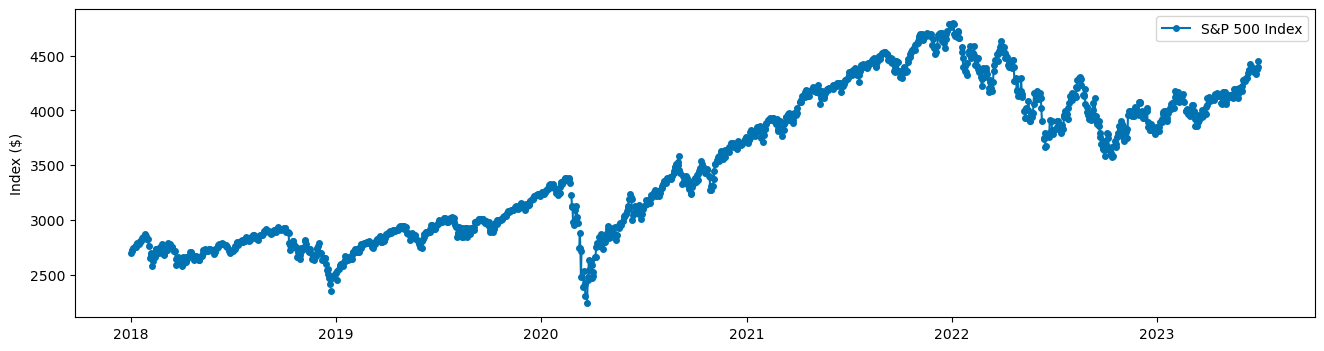

In [3574]:
plot_series(sp500_joined_df,
            y_label='Index ($)',
            labels=['S&P 500 Index'])

### Handling Missing Values - SP500 Index Data

In [3575]:
sp500_start_dt = np.datetime_as_string(date_df.iloc[0].values[0], unit='D') 
sp500_end_dt = np.datetime_as_string(date_df.iloc[4].values[0], unit='D')

sp500_start_mean = sp500_joined_df.loc[sp500_start_dt: sp500_end_dt, 'index'].mean()
print(f"S&P 500's mean index value was ${ round(sp500_start_mean, 2) } between the period of {sp500_start_dt} and {sp500_end_dt}.") 

S&P 500's mean index value was $2719.0 between the period of 2018-01-02 and 2018-01-06.


In [3576]:
# Replace the first two day's NaN values with the mean index value
sp500_1st_dt = np.datetime_as_string(date_df.iloc[0].values[0], unit='D') 
sp500_joined_df.loc[sp500_1st_dt, 'index'] = sp500_start_mean

sp500_2nd_dt = np.datetime_as_string(date_df.iloc[1].values[0], unit='D') 
sp500_joined_df.loc[sp500_2nd_dt, 'index'] = sp500_start_mean

In [3577]:
# Calculate the rolling mean index value over a window of 5 days
sp500_joined_df['index_rolling_mean'] = sp500_joined_df['index'].rolling(window=5, min_periods=2).mean()

In [3578]:
sp500_joined_df.head()

,index,index_rolling_mean
2018-01-02,2719.0025,NaN
2018-01-03,2719.0025,2719.00250
2018-01-04,2723.9900,2720.66500
2018-01-05,2743.1500,2726.28625
2018-01-06,NaN,2726.28625


In [3579]:
# Replace any NaN (missing) index values with the rolling mean index value value
for date_idx, row in sp500_joined_df.iterrows():

    sp500_index = sp500_joined_df.loc[date_idx, 'index']

    if np.isnan(sp500_index):

        sp500_joined_df.loc[date_idx, 'index'] = round(sp500_joined_df.loc[date_idx, 'index_rolling_mean'], 2)

In [3580]:
# Drop the 'index_rolling_mean' column from the dataframe
sp500_joined_df.drop(columns=['index_rolling_mean'], axis=1, inplace=True)

In [3581]:
# Sort the dataframe based on the dataframe's index dates
sp500_cleaned_df = sp500_joined_df.sort_index()

In [3582]:
sp500_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2006 entries, 2018-01-02 to 2023-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   2006 non-null   float64
dtypes: float64(1)
memory usage: 95.9 KB


In [3583]:
sp500_cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,2006.0,3507.618452,665.936938,2237.4,2871.9775,3414.04,4119.035,4796.56


(<Figure size 1600x400 with 1 Axes>, <Axes: xlabel='Date', ylabel='Index ($)'>)

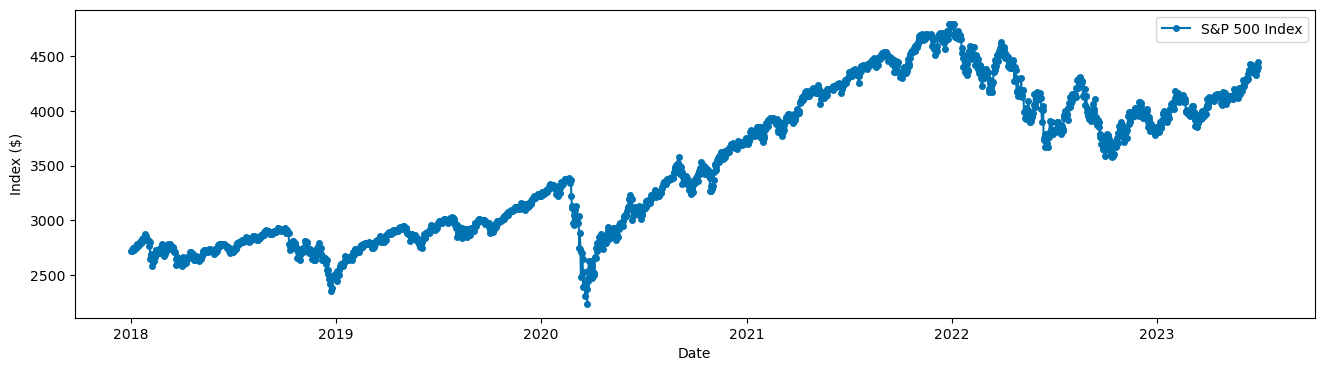

In [3584]:
plot_series(sp500_cleaned_df,
            y_label='Index ($)',
            x_label='Date',
            labels=['S&P 500 Index'])

### Apply MinMax Scaler

In [3585]:
microsoft_scaler = MinMaxScaler()
microsoft_scaler.fit(microsoft_cleaned_df[['close_price']])
microsoft_cleaned_df['close_price_scaled'] = microsoft_scaler.transform(microsoft_cleaned_df[['close_price']])

microsoft_cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
close_price,2006.0,201.846615,76.363303,85.01,126.787500,212.445000,264.250000,348.1
close_price_scaled,2006.0,0.444094,0.290255,0.00,0.158795,0.484378,0.681288,1.0


In [3586]:
sp500_scaler = MinMaxScaler()
sp500_scaler.fit(sp500_cleaned_df[['index']])
sp500_cleaned_df['index_scaled'] = sp500_scaler.transform(sp500_cleaned_df[['index']])

sp500_cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,2006.0,3507.618452,665.936938,2237.4,2871.977500,3414.040000,4119.035000,4796.56
index_scaled,2006.0,0.496342,0.260217,0.0,0.247963,0.459776,0.735255,1.00


### Display Microsoft's Stock Closing Price vs S&P 500 Index (Same Scale - 0 to 1)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='MinMax Scaled (0-1)'>)

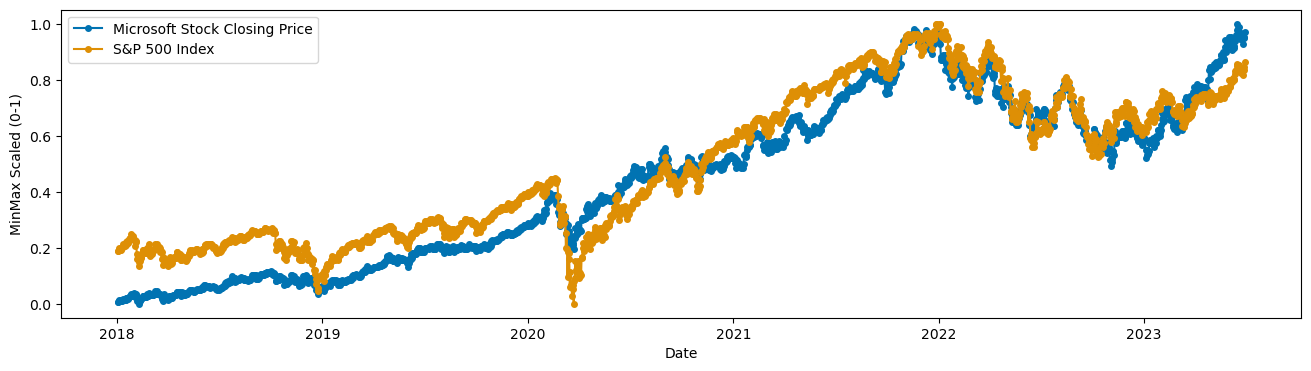

In [3587]:
plot_series(microsoft_cleaned_df.loc[:, 'close_price_scaled'].dropna(),
            sp500_cleaned_df.loc[:, 'index_scaled'].dropna(),
            y_label='MinMax Scaled (0-1)',
            x_label='Date',
            labels=['Microsoft Stock Closing Price', 'S&P 500 Index'])

### Display Microsoft's Stock Price Trend, Seasonality and Residual Components

In [3588]:
ms_df = microsoft_cleaned_df.loc['2023-01-01':end_date, 'close_price_scaled'].values.reshape(1,-1)[0]
sp_df = sp500_cleaned_df.loc['2023-01-01':end_date,'index_scaled'].values.reshape(1,-1)[0]

In [3589]:
tsr_df = pd.DataFrame(data={'microsoft': ms_df,
                            'sp500': sp_df},
                            index=pd.date_range(start='2023-01-01', periods=len(ms_df), freq='D'))

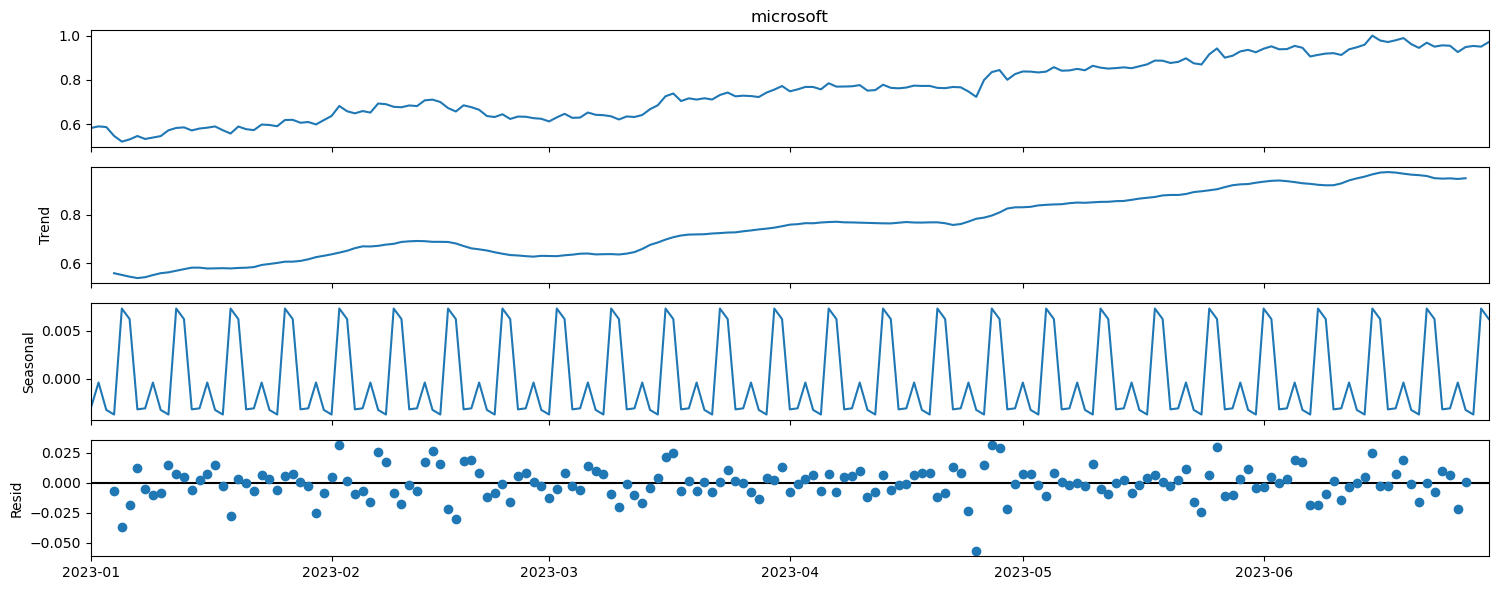

In [3590]:
result = seasonal_decompose(tsr_df['microsoft'], model='additive')
plt.rcParams['figure.figsize'] = [15, 6]
result.plot()
plt.show()

### Display S&P 500 Index Trend, Seasonality and Residual Components

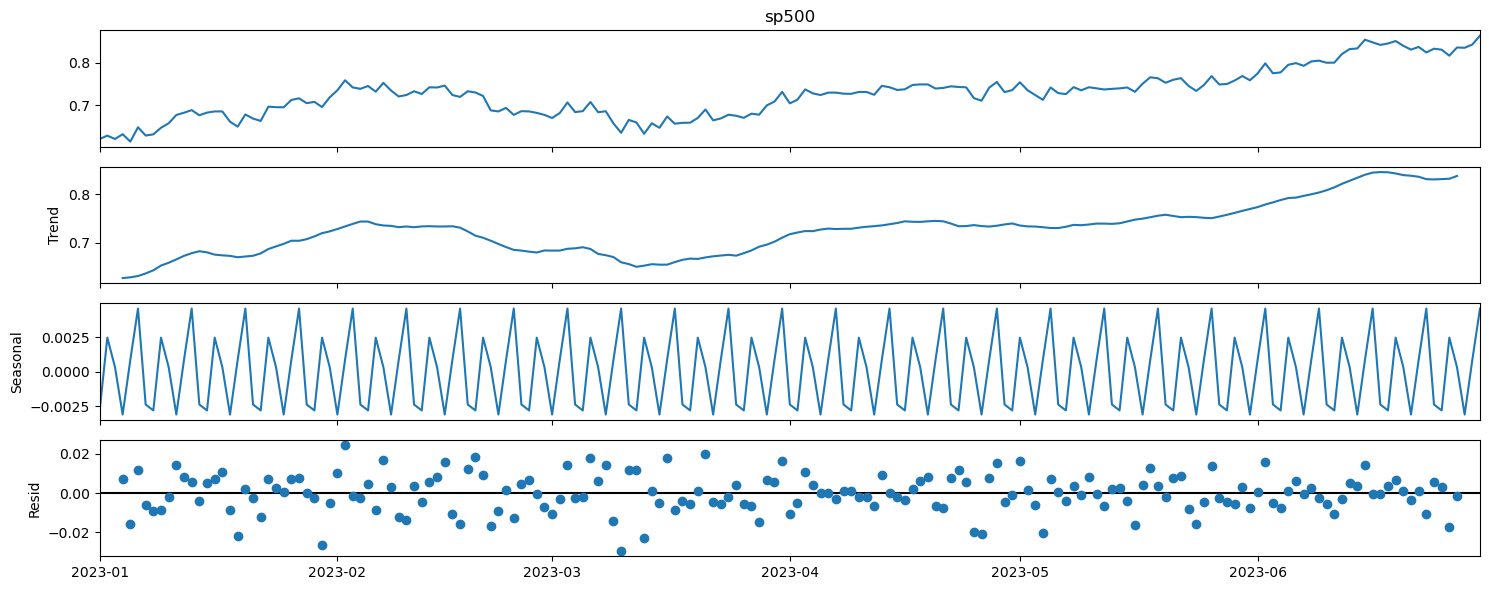

In [3591]:
result = seasonal_decompose(tsr_df['sp500'], model='additive')
plt.rcParams['figure.figsize'] = [15, 6]
result.plot()
plt.show()

### Augmented Dicky-Fuller Test for Stationarity (Before Applying Stationary Transformation)

In [3592]:
def adf(dataframe:pd.DataFrame):
    
    result = adfuller(dataframe.values)
    
    print(f"ADF Statistics: {round(result[0], 3)}")
    print(f"p-value: {round(result[1], 3)}")
    
    print("Critical values: ")
    for key, value in result[4].items():
        print(f"\t{key}: {round(value, 3)}")

In [3593]:
print('\nADF Test: Microsoft')
adf(dataframe=microsoft_cleaned_df['close_price_scaled'].dropna())


ADF Test: Microsoft
ADF Statistics: -0.43
p-value: 0.905
Critical values: 
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [3594]:
print('\nADF Test: SP500')
adf(dataframe=sp500_cleaned_df['index_scaled'].dropna())


ADF Test: SP500
ADF Statistics: -1.052
p-value: 0.734
Critical values: 
	1%: -3.434
	5%: -2.863
	10%: -2.568


The p-values for both microsoft's and Amazon's stock price data are above the 0.05 alpha level, therefore we conclude that their time series are NOT stationary.

### Augmented Dicky-Fuller Test for Stationarity (After Applying Stationary Transformation) 

In [3595]:
# Apply first differencing to remove trend and seasonality components from the time series
microsoft_transformed_df = microsoft_cleaned_df['close_price_scaled'].diff().dropna()

print('\nADF Test: Microsoft')
adf_test(microsoft_transformed_df)


ADF Test: Microsoft
ADF Statistics: -9.076
p-value: 0.0
Critical values: 
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [3596]:
# Apply first differencing to remove trend and seasonality components from the time series
sp500_transformed_df = sp500_cleaned_df['index_scaled'].diff().dropna()

print('\nADF Test: SP500')
adf_test(sp500_transformed_df)


ADF Test: SP500
ADF Statistics: -11.094
p-value: 0.0
Critical values: 
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [3597]:
stock_ts_df = pd.DataFrame(data={'microsoft': microsoft_transformed_df.values.reshape(1,-1)[0],
                                 'sp500': sp500_transformed_df.values.reshape(1,-1)[0]},
                                 index=pd.date_range(start=start_date, periods=microsoft_transformed_df.shape[0], freq='D'))

In [3598]:
stock_ts_df.describe().T

,count,mean,std,min,25%,50%,75%,max
microsoft,2005.0,0.000481,0.014238,-0.077806,-0.004713,0.000608,0.006576,0.075830
sp500,2005.0,0.000337,0.016364,-0.115499,-0.006350,0.000785,0.008065,0.090022


After the first difference were applied to both microsoft's and Amazon's stock price data, we can see that the p-values are now below 0.05 aplha level, and we conclude that the time series data is now stationary.

### Determine Maximum Number of Lags with AIC
1. Akaike Information Criterion (AIC)
    - The AIC is a measure used to compare different models by considering both the goodness-of-fit and the complexity of the model.

$AIC = N*ln(\frac{SS_e}{N}) + 2*k$

In [3599]:
# Create and fit the VAR model on training data
model = VAR(stock_ts_df)

# Select the optimal lag order using AIC
lag_order = model.select_order(maxlags=60)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.77      -17.76   1.918e-08      -17.77
1       -17.83      -17.81   1.814e-08      -17.82
2       -17.89      -17.86   1.695e-08      -17.88
3       -17.89      -17.85   1.697e-08      -17.88
4       -17.92     -17.87*   1.654e-08     -17.90*
5       -17.91      -17.85   1.658e-08      -17.89
6       -17.92      -17.84   1.657e-08      -17.89
7       -17.91      -17.83   1.659e-08      -17.88
8       -17.92      -17.82   1.654e-08      -17.88
9       -17.91      -17.81   1.660e-08      -17.87
10      -17.91      -17.79   1.665e-08      -17.87
11      -17.91      -17.78   1.662e-08      -17.86
12      -17.91      -17.77   1.666e-08      -17.86
13     -17.92*      -17.77  1.644e-08*      -17.87
14      -17.92      -17.75   1.650e-08      -17.86
15      -17.92      -17.74   1.653e-08      -17.85
16      -17.91      -17.73   1.

### Define Vector Autoregressive Model (VAR) with optimal lag parameter

In [3600]:
# Fit the model with the selected lag order
results = model.fit(lag_order.aic)
optimal_lag_order = lag_order.aic

### Apply Granger Causality Test - Check if Microsoft's closing stock prices Granger Causes the S&P 500 index ?

In [3601]:
gc_res = grangercausalitytests(stock_ts_df[['microsoft', 'sp500']], maxlag=optimal_lag_order)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.9056 , p=0.0000  , df_denom=2001, df_num=1
ssr based chi2 test:   chi2=28.9489 , p=0.0000  , df=1
likelihood ratio test: chi2=28.7418 , p=0.0000  , df=1
parameter F test:         F=28.9056 , p=0.0000  , df_denom=2001, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.6657 , p=0.0000  , df_denom=1998, df_num=2
ssr based chi2 test:   chi2=29.4048 , p=0.0000  , df=2
likelihood ratio test: chi2=29.1911 , p=0.0000  , df=2
parameter F test:         F=14.6657 , p=0.0000  , df_denom=1998, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9571  , p=0.0000  , df_denom=1995, df_num=3
ssr based chi2 test:   chi2=29.9762 , p=0.0000  , df=3
likelihood ratio test: chi2=29.7540 , p=0.0000  , df=3
parameter F test:         F=9.9571  , p=0.0000  , df_denom=1995, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.4202  , p=0.

### Apply Granger Causality Test - Check if the S&P 500 index Granger Causes Microsoft's closing stock prices ?

In [3602]:
gc_res = grangercausalitytests(stock_ts_df[['sp500', 'microsoft']], maxlag=optimal_lag_order)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1421  , p=0.0420  , df_denom=2001, df_num=1
ssr based chi2 test:   chi2=4.1483  , p=0.0417  , df=1
likelihood ratio test: chi2=4.1440  , p=0.0418  , df=1
parameter F test:         F=4.1421  , p=0.0420  , df_denom=2001, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1967  , p=0.0152  , df_denom=1998, df_num=2
ssr based chi2 test:   chi2=8.4145  , p=0.0149  , df=2
likelihood ratio test: chi2=8.3969  , p=0.0150  , df=2
parameter F test:         F=4.1967  , p=0.0152  , df_denom=1998, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5959  , p=0.0509  , df_denom=1995, df_num=3
ssr based chi2 test:   chi2=7.8150  , p=0.0500  , df=3
likelihood ratio test: chi2=7.7998  , p=0.0503  , df=3
parameter F test:         F=2.5959  , p=0.0509  , df_denom=1995, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8037  , p=0.